# Introduction
This notebook serves as an example for the process of the analysis of semantic similarity. Semantic similarity requires not simply comparing text, but comparing what the text is supposed to mean. Even people can have disagreements over this, so computing something that abstract is a complex task.

A concept of vital importance is text embedding. Text is relatively hard to compare; comparing numbers is significantly faster than comparing strings, the latter possibly requiring iterating over each character to check it. Transforming the text into a numerical representation brings a lot of efficiency, and is an important first step. There are multiple ways to go about this.

The simplest way is called <i>bag of words</i>. The entire vocabulary of the library of text we want to compare is numerically allocated; each word is given an entry in a simple lookup table. A sentence can then be vectorized, each vector being the same length as the lookup table, and each index holding the count of how often the word assigned that number appears in the sentence. Comparing these vectors then essentially compares the overlap between words used in sentences, assuming that the same words lead to the same meanings.

Of course, as the 'bag' implies, we lose order, a very important part of semantic meaning. Additionally, words may be functionally similar, but be different counts; two sentences each using different synonyms would be very different in this theory. 'Greater' could be stemmed to 'great', but the same is harder for 'better' and 'good'. What about 'terrific' and 'great'? We could look up synonyms for each word, but this quickly becomes very inefficient. Then there's the question of how relevant a word is; a 'I have a good book' is very different from a 'I have a good car', after all, despite being 80% "similar".

This relevancy problem can be diminished using TFIDF, or term frequency–inverse document frequency, to introduce a weighting. The more often a term shows up in a document, which is any arbitrary amount of text, the more relevant it is. The more documents that term shows up in, however, the less relevant. The sentences above may be reduced to 'good book' and 'good car', for example, based on the exact implementation. 

A more complex solution is to use a continuous bag of words such as described in the Word2Vec model as originally patented by Google, an implementation of which exists in the open source Gensim package. The concept is similar to a normal bag of words, but instead of each word apart, we look at the surrounding words. Each word is paired with its surroundings, creating a structure that allows for the prediction of words: using the above sentences again, 'good' can predict 'a', 'book', or 'car'. Then, TFIDF could be applied to determine the odds of predicting each word, or these weights can be determined more accurately using a neural network, as described in the original article. The Gensim package uses the latter method. The (abstracted) weights can be vectorized, and these are then used much like the simpler embedding can be.

To compare sentences, the embedded word vector can be taken for each word in the sentence, taking the average. Two averaged vectors can then be compared to determine how similar they are. This solves the relevancy and synonym problems, but does not preserve order; some context from sentence structure is lost. An expansion on the Word2Vec method, the Doc2Vec method, designed by the same authors, proposes to solve this by taking the word vectors in a document, and adding a 'phantom word'; the resulting so called document vector is then unique for that document, in an attempt to remember or at least account for the entire document context. This also has an implementation built in Gensim.

How long the resulting vector is, depends on the implementation. The Gensim implementations use a vector size of 100 by default. Larger vectors can capture more details, but make computation more expensive. In our case, 100 was an apt choice 

In the next cell, we load versions of these three models trained on the data provided to us, to show their capability. Additionally, a pretrained Google model known as the Universal Sentence Encoder will be shown.

# Data

In [1]:
from process import readdata, preprocess
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import pandas as pd

In [2]:
data = readdata.read()
data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0
5,5,11,12,astrology: i am a capricorn sun cap moon and c...,"i'm a triple capricorn (sun, moon and ascendan...",1
6,6,13,14,should i buy tiago?,what keeps childern active and far from phone ...,0
7,7,15,16,how can i be a good geologist?,what should i do to be a great geologist?,1
8,8,17,18,when do you use シ instead of し?,"when do you use ""&"" instead of ""and""?",0
9,9,19,20,motorola (company): can i hack my charter moto...,how do i hack motorola dcx3400 for free internet?,0


<AxesSubplot:>

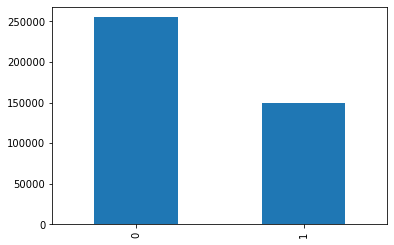

In [3]:
data['is_duplicate'].value_counts().plot(kind='bar')

In [4]:
clean_data = preprocess.clean_process(data)
clean_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, i, n...","[what, would, happen, if, the, indian, governm...",0
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat...",0
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0
5,5,11,12,"[astrology, i, am, a, capricorn, sun, cap, moo...","[i'm, a, triple, capricorn, sun, moon, and, as...",1
6,6,13,14,"[should, i, buy, tiago]","[what, keeps, childern, active, and, far, from...",0
7,7,15,16,"[how, can, i, be, a, good, geologist]","[what, should, i, do, to, be, a, great, geolog...",1
8,8,17,18,"[when, do, you, use, シ, instead, of, し]","[when, do, you, use, instead, of, and]",0
9,9,19,20,"[motorola, company, can, i, hack, my, charter,...","[how, do, i, hack, motorola, dcx3400, for, fre...",0


# Embedding Models

### Train embeddings 
run_w2v.py takes 3 minutes to train, while run_d2v.py takes 40 minutes to train. For time saving, run_d2v.py is off by default. In order to see the results of the d2v model, run run_d2v.py once.

In [5]:
%run run_w2v.py
# %run run_d2v.py

--- Reading data ---
--- Training model ---
W2V Model saved.


### Load embeddings

In [6]:
from gensim.models import word2vec, doc2vec
import pickle
from embed import universal_sentence_encoder as use_model

# Load the pretrained models
w2v_model = word2vec.Word2Vec.load("models/w2vmodel.mod")
w2v_vectors = w2v_model.wv

try:
    d2v_model = doc2vec.Doc2Vec.load("models/d2v/doc2vec.model")
except:
    d2v_model = 0
    
tfidf_NB = pickle.load(open("models/vectorizer_NB.p", "rb"))
tfidf_cosine = pickle.load(open("models/vectorizer_cosine.p", "rb"))

# Classification

The above models and instruction clarify how to embed text, acquiring vectors for the relevant documents. It mentions comparing these vectors, but not exactly how. There are, again, multiple ways to do this. The simplest way is to calculate the cosine similarity between them, essentially imagining we have position vectors, and checking the angle between them. This is relatively easy to compute, intuitive, and gives a result between 0 and 1, making it very easy to use; set or train a proper threshold, and if the cosine similarity is above that threshold, the sentences carry the same semantic intent.

A complexer but significantly more accurate way of comparing is through the use of a neural network. Starting with more-or-less random predictions, the correct answers are used to calculate how wrong the network's prediction was, which is then used to update it, improving the next prediction. Through repetition, the network thus learns how to tell which vectors are supposed to be 'similar', learning to classify them. We implemented a relatively simple neural network, that takes as input two concatenated vectors; the two sentence vectors we want to compare. One hidden layer, of equal size to the input layer, with as activation function the rectified linear activation function, and finally a sigmoid function for the output layer of size 1. This output is simply a 0 or 1, signifying whether the sentences are the same or not.

The training of this second method is rather computationally expensive, though training doesn't necessarily have happen more than once. However, it also requires a large amount of annotated data; a large list of sentence combinations of which it is known if they are semantically the same or not. Additionally, this data should be very varied, as scenarios not adequately present in the training data will be hard to predict. This data being accurate is also of vital importance for accuracy, meaning it will have to be done, or at least verified, by hand. Our data consisted of about 400000 pairs of questions, meaning the network is likely to be better at classifying questions than other sentence structures. While this machine learning is not applicable in every situation, the prerequisites are something to keep in mind.

Below we load our pretrained models, after which the requirements for analysis are present, and some examples can be run.

# Classifiers

In [7]:
from tensorflow import keras
from classifiers import binaryclassification as bc
from embed import w2vec, doc2vec, d2vec
import numpy as np
from nltk.tokenize import RegexpTokenizer
from scipy import spatial
import tensorflow as tf
import importlib

# Load the pretrained models
w2v_network = keras.models.load_model('neuralnets/w2v.h5')
d2v_network = keras.models.load_model('neuralnets/d2v.h5')
use_network = keras.models.load_model('neuralnets/use.h5')
NB_classifier = pickle.load(open("neuralnets/NB_classifier.pickle", "rb"))
tokenizer = RegexpTokenizer(r'\w+\'*\w*')



# Widget

In [11]:
def predict_models(text1, text2):
    tokens1 = tokenizer.tokenize(text1.lower())
    tokens2 = tokenizer.tokenize(text2.lower())

    ''' Preprocessing '''
    print('Preprocessing:')
    d = {'sentence':[tokens1, tokens2]}
    pd.set_option('display.max_colwidth',None)
    display(pd.DataFrame(data=d, index=['s1','s2']))

    ''' Vectorize '''
    w2v_vector = np.array([bc.vectorize_w2v(w2v_vectors, tokens1, tokens2)])
    if d2v_model == 0:
        d2v_vector = 0
        print('Results for D2V are turned off')
    else:
        d2v_vector = np.array([d2vec.doc2vec(d2v_model, tokens1, tokens2)])
        print('Results for D2v are turned on')
    use_vector = tf.convert_to_tensor(np.array(tf.concat([use_model.encode(text1), use_model.encode(text2)], axis=0)).reshape((1, 1024)))
    tfidf_NB_vector = tfidf_NB.transform([text1+text2])
    tfidf_cosine_vector = tfidf_cosine.transform([text1, text2])

    ''' Create list of classifier predictions '''
    classifier_preds = []
    classifier_preds.append((w2v_network.predict(w2v_vector) > 0.5).astype("int32")[0][0] == 1)
    if isinstance(d2v_vector, int):
        classifier_preds.append(False)
    else:
        classifier_preds.append((d2v_network.predict(d2v_vector) > 0.5).astype("int32")[0][0] == 1)
    classifier_preds.append((use_network.predict(use_vector) > 0.5).astype("int32")[0][0] == 1)
    classifier_preds.append(NB_classifier.predict(tfidf_NB_vector)[0] == 1)

    ''' Create list of cosine predictions '''
    cosine_preds = []
    cosine_preds.append(w2vec.string_similarity(w2v_model, tokens1, tokens2) > 0.98)
    if isinstance(d2v_vector, int):
        cosine_preds.append(False)
    else:
        cosine_preds.append((1 - spatial.distance.cosine(d2v_vector[0][:100], d2v_vector[0][100:])) > 0.98)
    cosine_preds.append((1 - spatial.distance.cosine(use_vector[0][:512], use_vector[0][512:])) > 0.98)
    cosine_preds.append(((tfidf_cosine_vector * tfidf_cosine_vector.T).A)[0,1] > 0.98)

    ''' Combine predictions '''
    preds = []
    preds.append(classifier_preds)
    preds.append(cosine_preds)

    ''' Create Dataframe '''
    df = pd.DataFrame(preds, index=['Classifier','Cosine'], columns=['W2V','D2V','USE','TFIDF'])
    print('\n\nPredictions:')
    return df

def on_butt_clicked(b):
    with out:
        out.clear_output()
        display(predict_models(sentence1.value, sentence2.value))
        

# Run Widget

In [9]:
l = widgets.Layout(height = '80px', width='500px')

sentence1 = widgets.Textarea(description = 'sentence1', value = "What is the best programming language to learn?", layout = l)
sentence2 = widgets.Textarea(description = 'sentence2', value = "Which programming languages are considered to be the best?", layout = l)
submit =  widgets.Button(description="predict")
out = widgets.Output()

submit.on_click(on_butt_clicked)

display(sentence1, sentence2, submit, out)

Textarea(value='What is the best programming language to learn?', description='sentence1', layout=Layout(heigh…

Textarea(value='Which programming languages are considered to be the best?', description='sentence2', layout=L…

Button(description='predict', style=ButtonStyle())

Output()